# TODO
- iteratively layernorm each size of matryoshka embedding to ensure they're all on the surface of hyperspheres corresponding to the size of the embedding so that cosine similarity actually means something for the smaller vectors
- annotate well so someone reading can understand

#### !!!! DO NOT RUN THIS FIRST CELL UNLESS YOU HAVE THE SAME VENV PATH ISSUE THAT I DO

In [1]:
import sys
sys.path.append('/Users/tunadorable/local-repos/ng-video-lecture/venv/lib/python3.11/site-packages')

# in this notebook we'll impose a hierarchy on our matryoshka embeddings when training a GPT

this means they're no longer "matryoshka" in the sense that the smaller ones are no longer self-similar to the larger ones

rather, the smaller ones will correspond to hierarchical categories that the larger embeddings fit into

for example, if our nested embedding sizes are `[4,8]` and our token vocabulary consists of only vowels ['A', 'a', 'E', 'e', 'I', 'i', 'O', 'o', 'U', 'u', 'Y', 'y'] then we will impose the categories of *uppercase letters* versus *lowercase letters*, giving us the two groups ['A', 'E', 'I', 'O', 'U', 'Y'] and ['a', 'e', 'i', 'o', 'u', 'y'] respectively. 

The way this will look during training is that the length `8` embedding vectors will be trained with normal one-hot vectors and cross-entropy-loss to predict a given character. Meanwhile, the length `4` subset of the length `8` vectors will have another added optimization pressure on it; to predict the concept of "uppercase" vs "lowercase." The way this works is that in the cross-entropy loss function, instead of using one-hot vectors on the length `4` subsets, we'll use multi-hot vectors that contain decimals instead of 1's. For example,

The one-hot vector that goes into CE loss to encourage prediction of 'A' on the length `8` embedding vector
`[1,0,0,0,0,0,0,0,0,0,0,0]`

The one-hot vector that goes into CE loss to encourage prediction of 'a' on the length `8` embedding vector
`[0,1,0,0,0,0,0,0,0,0,0,0]`

The multi-hot vector that goes into CE loss to encourage prediction of *uppercase letters* on the length `4` subset embedding vector
`[0.1667,0,0.1667,0,0.1667,0,0.1667,0,0.1667,0,0.1667,0]`

The multi-hot vector that goes into CE loss to encourage prediction of *lowercase letters* on the length `4` subset embedding vector
`[0,0.1667,0,0.1667,0,0.1667,0,0.1667,0,0.1667,0,0.1667]`

As you can see, they decimals are weighted by the total number of tokens in the category ($1 \div 6 = 0.1667$) thus ensuring that loss amounts behave in CE loss given the use of a softmax

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
from typing import List
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [4]:
# hyperparameters
b = 4 # how many independent sequences will we process in parallel?
t = 16 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 50
lr = 3e-4 # learning rate for each backprop step
eval_iters = 20
h = 4 # number of attention heads
l = 4 # number of transormer layers
dropout = 0.2 # % of parameters to ignore every iteration
l2 = 0.01 # multiplier for our L2 norm to encourage sparsity

# embedding aka hidden dimension. this is the largest that th emodel will have
d = 32
power_of_d = int(math.log2(d))
# the smallest power of 2 we'll be considering as a matryoshka embedding
min_power = 1 # Starting from 2^min_power
nesting_list = [2**i for i in range(min_power, int(power_of_d) + 1)]
print(nesting_list)

[2, 4, 8, 16, 32]


In [5]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
v = len(chars)
print(chars, v)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


In [6]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# creating a semantic hierarchy of tokens to impose on the model

let's take a look at these characters. idk about you, but the most obvious divide i see here is between alphabetical vs symbol tokens. we'll impose that as our primary category

next, i'm thinking we split up alphabetical into capital & lowercase, and split up symbols into "end of sentence," "middle of sentence," and then leave some stragglers to not be categorized (yes, that's something we can do!)

In [7]:
####################### V1 SCHIZMS ######## DO NOT DELETE ####################

##### first schizm, for our smallest embedding size
symbols = ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?']
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 
           'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 
           'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

##### second schizm, for our next smallest embedding size
# symbols: others include ['\n', , '3', ':'] but we won't need to define them, we can just let their embeddings run free
endofsentence = ['!','.','?']
midsentence = [' ', '$', '&', "'", ',', '-', ';']
# letters
uppercase = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
lowercase = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

##### third schizm
# symbols: i don't see any need for another schizm layer here so we could leave them be, but let's try this
spaces = ['\n', ' ']
# letters: not sure which of these to use yet. i think i can figure out how to combine them later
vowels = ['A', 'a', 'E', 'e', 'I', 'i', 'O', 'o', 'U', 'u', 'Y', 'y'] # notice how Y is in both
consonants = ['B', 'b', 'C', 'c', 'D', 'd', 'F', 'f', 'G', 'g', 'H', 'h', 'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n', 'P', 'p', 'Q', 'q', 'R', 'r', 'S', 's', 'T', 't', 'V', 'v', 'W', 'w', 'X', 'x', 'Y', 'y', 'Z', 'z']
#uppercase_vowels = ['A', 'E', 'I', 'O', 'U', 'Y']
#lowercase_vowels = ['a', 'e', 'i', 'o', 'u', 'y']
#uppercase_consonants = ['B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z']
#lowercase_consonants = ['b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']

##### fourth schizm
A = ['A', 'a']
B = ['B', 'b']
C = ['C', 'c']
D = ['D', 'd']
E = ['E', 'e']
F_ = ['F', 'f'] # so that F doesn't mess with pytorch's F.softmax & whatnot
G = ['G', 'g']
H = ['H', 'h']
I = ['I', 'i']
J = ['J', 'j']
K = ['K', 'k']
L = ['L', 'l']
M = ['M', 'm']
N = ['N', 'n']
O = ['O', 'o']
P = ['P', 'p']
Q = ['Q', 'q']
R = ['R', 'r']
S = ['S', 's']
T = ['T', 't']
U = ['U', 'u']
V = ['V', 'v']
W = ['W', 'w']
X = ['X', 'x']
Y = ['Y', 'y']
Z = ['Z', 'z']
alphabet_lists = [A, B, C, D, E, F_, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z]

In [8]:
def create_modified_matrix(vocabulary, groups):
    """
    Creates a modified matrix V based on the vocabulary and groups provided.

    Parameters:
    - vocabulary: A list of characters representing the vocabulary.
    - groups: A list of lists, where each inner list represents a group of characters for which 
              we want to create "multi-hot" vectors in the matrix.

    Returns:
    - A modified matrix V where each row corresponding to characters in any group is a "multi-hot" vector,
      and the matrix is normalized by the sum along the last dimension.
    """
    global device
    v = len(vocabulary)
    V = torch.eye(v, device=device)

    for group in groups:
        group_indices = torch.tensor([vocabulary.index(token) for token in group])
        V[group_indices] = 0  # Reset rows corresponding to the group symbols to 0
        V[group_indices[:, None], group_indices] = 1  # Set columns of group indices in group rows to 1

    # Normalize V by dividing each row by the sum of the elements in that row
    mask = V / V.sum(-1, keepdim=True)

    return mask

In [9]:
# Example usage with a smaller vocabulary so that the matrix we're looking at isn't too big
symbols = ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?']
endofsentence = ['!', '.', '?']
midsentence = [' ', '$', '&', "'", ',', '-', ':', ';']

groups = [endofsentence, midsentence]  # You can add more groups as needed

# Call the function with the example vocabulary and groups
modified_matrix = create_modified_matrix(symbols, groups)
print(modified_matrix)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1250, 0.0000, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000,
         0.0000, 0.1250, 0.1250, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
         0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.1250, 0.0000, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000,
         0.0000, 0.1250, 0.1250, 0.0000],
        [0.0000, 0.1250, 0.0000, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000,
         0.0000, 0.1250, 0.1250, 0.0000],
        [0.0000, 0.1250, 0.0000, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000,
         0.0000, 0.1250, 0.1250, 0.0000],
        [0.0000, 0.1250, 0.0000, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000,
         0.0000, 0.1250, 0.1250, 0.0000],
        [0.0000, 0.1250, 0.0000, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.0000,
         0.0000, 0.1250, 0.1250, 0.0000],
        [0.0000,

so with this matrix above, we see that we've got 3 observed values: 0, 1/3, and 1/8. this is because while our total vocabulary (the `symbols` object) has 13 objects, our first group (the `endofsentence` object) has 3 and the second group (the `midsentence` object) has 8. Matrices like this one (although rn for example's sake we're not using the full vocabulary) act as masks at a given embedding dimension length that we can pass into our custom cross-entropy loss function 

Let's build the actual mask vectors that we'll be using. Remember our matryoshka embedding sizes are `[4,8,16,32]`. The smallest size `4` will be utilized for our first schizm between `letters` vs `symbols`, the next size `8` for our second schizm between `endofsentence` vs `midsentence` & extras in the case of symbols and between `uppercase` vs `lowercase` in the case of letters

*how am i doing thsi third schizm?*

In [10]:
def create_mask_list(v: int, nesting_list: List, masks: List):
    """
    takes in the predetermined masks and fills out a full list with torch.eye()'s for whatever levels haven't been given groups
    """
    global device
    
    g = len(nesting_list)
    m = len(masks)
    for i in range(g-m):
        masks.append(torch.eye(v, device=device))

    return masks

mask_0 = create_modified_matrix(chars, [symbols, letters])
mask_1 = create_modified_matrix(chars, [endofsentence, midsentence, uppercase, lowercase])

# for now i'll use this as the third schizm
# notice how our lower-levels don't even necessarily need to be subsets of the higher levels
# fingers crossed tho we'll see if that actually works after i test the first two
mask_2 = create_modified_matrix(chars, [spaces, vowels, consonants])

# and then the crazy one for the fourth schizm
mask_3 = create_modified_matrix(chars, alphabet_lists)

masks = create_mask_list(v, nesting_list, [mask_0, mask_1, mask_2, mask_3])
print("masks: ", len(masks), "\nfinal mask: ", masks[-1])

masks:  5 
final mask:  tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='mps:0')


### back to regular model stuff

In [11]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [12]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - t, (b,))
    x = torch.stack([data[i:i+t] for i in ix])
    y = torch.stack([data[i+1:i+t+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [13]:
# so you can see what the tokenized data looks like
x,y = get_batch('train')
print("x ", x.shape, "\n", x)
print("y ", y.shape, "\n", y)

x  torch.Size([4, 16]) 
 tensor([[39, 47, 52, 58, 63,  1, 58, 53,  1, 40, 43,  1, 58, 46, 43,  1],
        [ 1, 46, 43, 39, 58,  6,  0, 32, 46, 39, 58,  1, 58, 46, 53, 59],
        [ 1, 58, 46, 43, 56, 43, 44, 53, 56, 43,  6,  1, 21,  1, 40, 43],
        [ 1, 46, 47, 57,  1, 56, 39, 54, 47, 43, 56,  5, 57,  1, 54, 53]],
       device='mps:0')
y  torch.Size([4, 16]) 
 tensor([[47, 52, 58, 63,  1, 58, 53,  1, 40, 43,  1, 58, 46, 43,  1, 49],
        [46, 43, 39, 58,  6,  0, 32, 46, 39, 58,  1, 58, 46, 53, 59,  1],
        [58, 46, 43, 56, 43, 44, 53, 56, 43,  6,  1, 21,  1, 40, 43, 57],
        [46, 47, 57,  1, 56, 39, 54, 47, 43, 56,  5, 57,  1, 54, 53, 47]],
       device='mps:0')


In [14]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # sets model to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # just resets to training mode
    return out

In [15]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 4 * d),
            nn.ReLU(),
            nn.Linear(4 * d, d),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [16]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(d, head_size, bias=False)
        self.query = nn.Linear(d, head_size, bias=False)
        self.value = nn.Linear(d, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(t, t))) # mask future timestesps
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        b,t,d = x.shape
        k = self.key(x)   # (b,t,d/h)
        q = self.query(x) # (b,t,d/h)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (b, t, d/h) @ (b, d/h, t) -> (b, t, t)
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float('-inf')) # (b, t, t)
        wei = F.softmax(wei, dim=-1) # (b, t, t)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (b,t,d/h)
        out = wei @ v # (b, t, t) @ (b, t, d/h) -> (b, t, d/h)
        return out

In [17]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, h, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(h)])
        self.proj = nn.Linear(head_size * h, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [18]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d, h):
        # d: embedding dimension, h: the number of heads we'd like
        super().__init__()
        head_size = d // h # the double backslash just makes the output an int instead of float
        self.sa = MultiHeadAttention(h, head_size)
        self.ffwd = FeedFoward(d)
        self.ln = nn.LayerNorm(d, elementwise_affine=False)

    def forward(self, x):
        x = x + self.sa(self.ln(x))
        x = x + self.ffwd(self.ln(x))
        return x

### here's the masked loss function we'll be using for each embedding dimension
the idea is that it computes regular CE loss, except isntead of one-hots it uses the multi-hot masks from `create_modified_matrix()`

In [19]:
class GroupCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(GroupCrossEntropyLoss, self).__init__()

    def forward(self, logits, targets, group_mask):
        # Apply softmax to model outputs to get probabilities
        probs = F.softmax(logits, dim=-1)
        
        # Use advanced indexing to select the relevant group masks for each target in the batch
        target_group_masks = group_mask[targets]  # Shape: (b, t, v), automatically broadcasts targets
        
        # Compute the element-wise loss, multiplying the probabilities by the target group masks
        elementwise_loss = -torch.log(probs) * target_group_masks
        
        # Sum the losses over the vocabulary dimension and average over all other dimensions
        loss = elementwise_loss.sum(dim=-1).mean()
        
        return loss

### let's walk through an example of how it calculates loss

here all the code is the same as what's present in the above `GroupCrossEntropyLoss()` function, but expanded out, commented, and with print statements so that you can really see what's happening

In [20]:
# the logits outputted by the GPT model
logits = torch.randn((2,5,6)) # so batch size of 2, context length of 5, and vocabulary size of 6
print("logits: ", logits.shape, "\n", logits)

# Apply softmax to model outputs to get probabilities
probs = F.softmax(logits, dim=-1)
print("probs: ", probs.shape, "\n", probs)

targets = torch.randint(6, (2,5))
print("targets: ", targets.shape, "\n", targets)

# here with this example mask, the first three tokens are grouped together, the 4th and 5th are grouped, and the 6th is left alone
multi_hot_mask = torch.tensor([[1,1,1,0,0,0],
                              [1,1,1,0,0,0],
                              [1,1,1,0,0,0],
                              [0,0,0,1,1,0],
                              [0,0,0,1,1,0],
                              [0,0,0,0,0,1]])

# normalizing to sum to 1 since CE loss expects everything to be interpretable in terms of probabilities
mask = multi_hot_mask / multi_hot_mask.sum(-1)
print("mask: ", mask)

# Use indexing to select the relevant group masks for each target in the batch
target_group_masks = mask[targets]  # Shape: (b, t, v), automatically broadcasts targets
print("target_group_masks: ", target_group_masks.shape, "\n", target_group_masks)

# Compute the element-wise loss, multiplying the probabilities by the target group masks
# This is equivalent to summing the log probabilities for the correct classes in the group
elementwise_loss = -torch.log(probs) * target_group_masks
print("elementwise_loss: ", elementwise_loss.shape, "\n", elementwise_loss)

# Sum the losses over the vocabulary dimension 
loss_per_token = elementwise_loss.sum(dim=-1)
print("loss_per_token: ", loss_per_token.shape, "\n", loss_per_token)

# finally average over all tokens to get loss number for  this matryoshka embedding size
loss = loss_per_token.mean()
print("loss: ", loss)

logits:  torch.Size([2, 5, 6]) 
 tensor([[[-0.5264,  0.2874, -1.4422,  1.0871,  1.0043, -0.6341],
         [-0.6611,  1.4481, -1.4359, -0.4810,  0.1905,  0.9839],
         [-0.8274,  1.2150,  0.2354, -2.1638,  0.2661, -0.1500],
         [ 0.1147, -0.1170, -0.4392, -0.2822,  0.6806, -1.1564],
         [-0.2208,  0.0577, -0.9421, -1.0713,  0.0468,  1.5263]],

        [[-1.2824,  0.6666, -0.4397, -0.4019,  0.0435, -1.0973],
         [ 0.7866, -1.0657, -1.6069, -0.7923, -2.1435, -0.5373],
         [-1.5081,  0.4295,  0.1654, -0.2491,  0.4047, -0.3035],
         [ 1.6661, -0.9807,  1.3613, -0.7104, -1.7638,  0.3300],
         [-0.8515, -1.0215, -1.3379, -0.3879, -1.6962,  1.3131]]])
probs:  torch.Size([2, 5, 6]) 
 tensor([[[0.0704, 0.1589, 0.0282, 0.3536, 0.3255, 0.0633],
         [0.0543, 0.4473, 0.0250, 0.0650, 0.1272, 0.2812],
         [0.0595, 0.4583, 0.1721, 0.0156, 0.1775, 0.1171],
         [0.1968, 0.1561, 0.1131, 0.1323, 0.3465, 0.0552],
         [0.0973, 0.1285, 0.0473, 0.0416, 0.1

In [21]:
class Hierarchical_CE_Loss(nn.Module):
    '''
    Loss function for Hierarchical Representation Learning 
    with fraction multi-hot vectors of categories instead of one-hot on specific dimension lengths
    '''
    def __init__(self, relative_importance: List[float]=None, **kwargs):
        super(Hierarchical_CE_Loss, self).__init__()
        # should i be including `Hierarchical_Matryoshka_CE_Loss` in the super? i don't remember putting it there
        
        #self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.criterion = GroupCrossEntropyLoss()
        
        # relative importance shape: [G]
        # this is optional for if you want to weight them differently
        self.relative_importance = relative_importance

    def forward(self, logits, targets, masks: List):
        # logits shape: length g tuple with tensors size [b batch size, t sequence length, v number of classes]
        g = len(logits)
        b,t,v = logits[-1].shape
        
        # targets shape: [b, t]
        
        # masks shape: length g list with tensors size [v,v]
        # the masks are multi-hot vectors where the "hot" part is multiple values to demonstrate a category, 
        # except instead of 1's they're fractions so as to not confuse the model nor mess with the loss

        # Calculate losses for each output and stack them
        #losses = torch.stack([self.criterion(logits_i.view(b*t, v), targets.view(b*t)) for logits_i in logits])
        losses = torch.stack([self.criterion(logits[i], targets, masks[i]) for i in range(g)])

        # Set relative_importance to 1 if not specified
        # I don't think i'm gonna be emssing around with this part
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.tensor(self.relative_importance)

        # Apply relative importance weights
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

In [22]:
class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list: List, num_classes=v, passed_in_layer=None, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes  # Number of classes for classification
        
        self.passed_in_layer = passed_in_layer  # Store reference to the embedding layer
        self.use_passed_in_layer = passed_in_layer is not None
        if not self.use_passed_in_layer:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, bias=False, device=device, **kwargs)
        
        # Initialize layer normalization
        self.layer_norm = nn.LayerNorm(nesting_list[-1], elementwise_affine=False)

    def forward(self, x):
        if self.use_passed_in_layer:
            # Apply layer normalization on the fly during the forward pass
            normed_passed_in_layer = self.layer_norm(self.passed_in_layer)
            nesting_classifier_0 = normed_passed_in_layer.t().to(x.device)
        else:
            nesting_classifier_0 = self.nesting_classifier_0

        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            nesting_logits += (torch.matmul(x[..., :num_feat], nesting_classifier_0[:num_feat, :]),)
        
        return nesting_logits

In [23]:
class imposed_hierarchical_embeddings_GPT(nn.Module):

    def __init__(self, masks: List):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(v, d).to(device)
        
        # simple learned positional encodings rather than sine or RoPE
        self.position_embedding_table = nn.Embedding(t, d) 
        self.blocks = nn.Sequential(*[Block(d, h) for _ in range(l)]) # bulk of the beast
        self.ln = nn.LayerNorm(d, elementwise_affine=False) # final layer norm

        ### MATRYOSHKA OUTPUT HEADS
        self.m_head = MRL_Linear_Layer(nesting_list = nesting_list, passed_in_layer = self.token_embedding_table.weight)
        
        ### HIERARCHICAL LOSS
        self.m_loss = Hierarchical_CE_Loss()

        ### masks for hierarchical loss
        self.masks = masks
        
        # initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        b, t = idx.shape
        # idx and targets are both (b,t) tensor of integers
        
        pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (t,d)
        tok_emb = self.token_embedding_table(idx) # (b,t,d)
        x = self.ln(tok_emb) + pos_emb
        
        x = self.blocks(x) # (b,t,d) -> (b,t,d)
        x = self.ln(x) # (b,t,d) -> (b,t,d)

        # Matryoshka output head
        logits = self.m_head(x) # tensor [b,t,d] -> tuple ([b,t,d_0], [b,t,d_1], [b,t,d_2],..., [b,t,d_g])
        
        if targets is None:
            loss = None
        else:
            loss = self.m_loss(logits, targets, self.masks) # (g,[b,t,d]) & (b,t) & (g,[v,v]) -> float

        return logits, loss

    def generate(self, idx, max_new_tokens, degree=power_of_d):
        assert degree >= min_power & degree <= power_of_d
        # idx is (b, t) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -t:]
            # get the predictions
            logits, loss = self(idx_cond)
            # select the desired degree
            logits = logits[degree-min_power]
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (b, d)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (b, d)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (b, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (b, t+1)
        return idx

# training

In [24]:
model = imposed_hierarchical_embeddings_GPT(masks).to(device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')

52.512 K parameters


In [92]:
start_time = time.time()

# Enable anomaly detection
#torch.autograd.set_detect_anomaly(True)

for iter in range(max_iters):

    # sample a batch of data
    xb, yb = get_batch('train')
    
    # train
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time elapsed: {elapsed_time:.2f} seconds")

# Disable anomaly detection after the training loop
#torch.autograd.set_detect_anomaly(False)

step 0: train loss 16.2109, val loss 16.2019, time elapsed: 0.16 seconds
step 50: train loss 16.3975, val loss 16.2161, time elapsed: 6.93 seconds
step 100: train loss 16.2730, val loss 16.3227, time elapsed: 13.61 seconds
step 150: train loss 16.1392, val loss 16.4623, time elapsed: 20.30 seconds
step 200: train loss 16.4013, val loss 16.3499, time elapsed: 26.92 seconds
step 250: train loss 16.4477, val loss 16.3436, time elapsed: 33.57 seconds
step 300: train loss 16.2186, val loss 16.0595, time elapsed: 40.19 seconds
step 350: train loss 16.0742, val loss 16.5063, time elapsed: 46.90 seconds
step 400: train loss 16.3491, val loss 16.2849, time elapsed: 53.53 seconds
step 450: train loss 16.2386, val loss 16.2206, time elapsed: 60.15 seconds
step 500: train loss 16.0603, val loss 16.2730, time elapsed: 66.78 seconds
step 550: train loss 16.0918, val loss 16.2561, time elapsed: 73.38 seconds
step 600: train loss 16.4085, val loss 16.1955, time elapsed: 80.00 seconds
step 650: train l

# save the trained model

In [108]:
#### HOW DO I HOLD THE CATEGORIES IN THE MODEL NAME? JUST LIST OFF THE ENTIRE CATEGORIES IN TEH NAME AND MAKE IT LONG AF????
torch.save(model.state_dict(), f'models/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_V1.pth')

# Load a saved model

In [ ]:
model = imposed_hierarchical_embeddings_GPT().to(device)  # Initialize a model with the same architecture

# Load the saved state dictionary
model.load_state_dict(torch.load('models/imposed_hierarchical_embeddings_GPT_b4_t16_d32_h4_l4_lr0.0003_drop0.2_l2-0.01_min_power1_2024-02-07|23-26-59_V1.pth'))

# If you plan to continue training the model, switch to training mode
#model.train()

# If you only plan to do inference, switch to evaluation mode
model.eval()

# Inference

In [28]:
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou R" # the classic line
context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)

In [93]:
%%time
# using only the smallest embedding to generate
###### i think i might need to remove this ability for this model
output = model.generate(context_tensor, max_new_tokens=100, degree = min_power)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou RssMbe
xuY'HYCAGvWuk!;3'$??
Rd BEWWGhj-jaowI bhF
SVSjFfnO.;'WaD?'$TKQwviYQGp' BnpeXNnKZgj:;$'ftO.;$Gm
CPU times: user 2.92 s, sys: 121 ms, total: 3.04 s
Wall time: 3.06 s


In [94]:
%%time
# using only the smallest embedding to generate
###### i think i might need to remove this ability for this model
output = model.generate(context_tensor, max_new_tokens=100, degree = min_power+1)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou Rwfstmukiy:: Rgjse. Gvbxujs&gzbizibkkrzhH
Xs;
Nppaopk'd$Nxsqkdus;
Mwrchf-,;

Tvy;;,'unchubqk$
YxttWhg
CPU times: user 2.87 s, sys: 96.5 ms, total: 2.97 s
Wall time: 2.99 s


In [95]:
%%time
# using the largest embedding to generate
output = model.generate(context_tensor, max_new_tokens=100, degree = power_of_d-1)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou RoCArYeThENCuSe:
ShEng shAND SHeeET foUSoUrTt:
aWELO TiToThIt CiFos yaYOmI SHaDO SBrOOrreTI nCAtOF: s
CPU times: user 2.85 s, sys: 95.9 ms, total: 2.95 s
Wall time: 2.97 s


In [96]:
%%time
# using the largest embedding to generate
output = model.generate(context_tensor, max_new_tokens=100, degree = power_of_d)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou Roo weng Yacumif min:
Braaf wsit is wupu, my cor,
Aced!
In wy soure,
LEng sind zeastore  ron simthe t
CPU times: user 2.86 s, sys: 95.1 ms, total: 2.95 s
Wall time: 2.97 s


In [85]:
def plot_token_similarity(tokens, model, stoi, degree, nesting_list=nesting_list, size=6, save_path=None):
    # Initialize a matrix to store cosine similarities
    similarity_matrix = np.zeros((len(tokens), len(tokens)))

    degree = nesting_list[degree-min_power]
    
    # Calculate cosine similarity for each pair of tokens
    for i, token1 in enumerate(tokens):
        for j, token2 in enumerate(tokens):
            if i >= j:  # Only compute for lower triangle
                index1 = stoi[token1]
                index2 = stoi[token2]
                embedding1 = model.token_embedding_table.weight[index1]
                embedding2 = model.token_embedding_table.weight[index2]
                similarity = F.cosine_similarity(embedding1[:degree].unsqueeze(0), embedding2[:degree].unsqueeze(0))
                similarity_matrix[i, j] = similarity.item()
    
    # Mask the upper triangular part of the matrix
    mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

    # Plotting
    fig, ax = plt.subplots(figsize=(size, size))
    # Use masked array to hide the upper triangle
    cax = ax.matshow(np.ma.masked_array(similarity_matrix, mask), cmap='viridis', vmin=-1, vmax=1)
    fig.colorbar(cax)

    # Set axis labels to the tokens
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False)

    # Label axes
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Tokens')
    ax.set_title(f'Cosine Sim bw Embeddings of degree {degree}')

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        
    # Show the plot
    plt.show()

In [86]:
# reordering chars so that it more clearly shows some of the categories i expect to emerge
chars1 = ['\n', '3',
          '!','.','?', 
          ' ', '$', '&', "'", ',', '-', ':', ';',
        'A', 'E', 'I', 'O', 'U', 
        'B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z',
        'a', 'e', 'i', 'o', 'u', 
        'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']

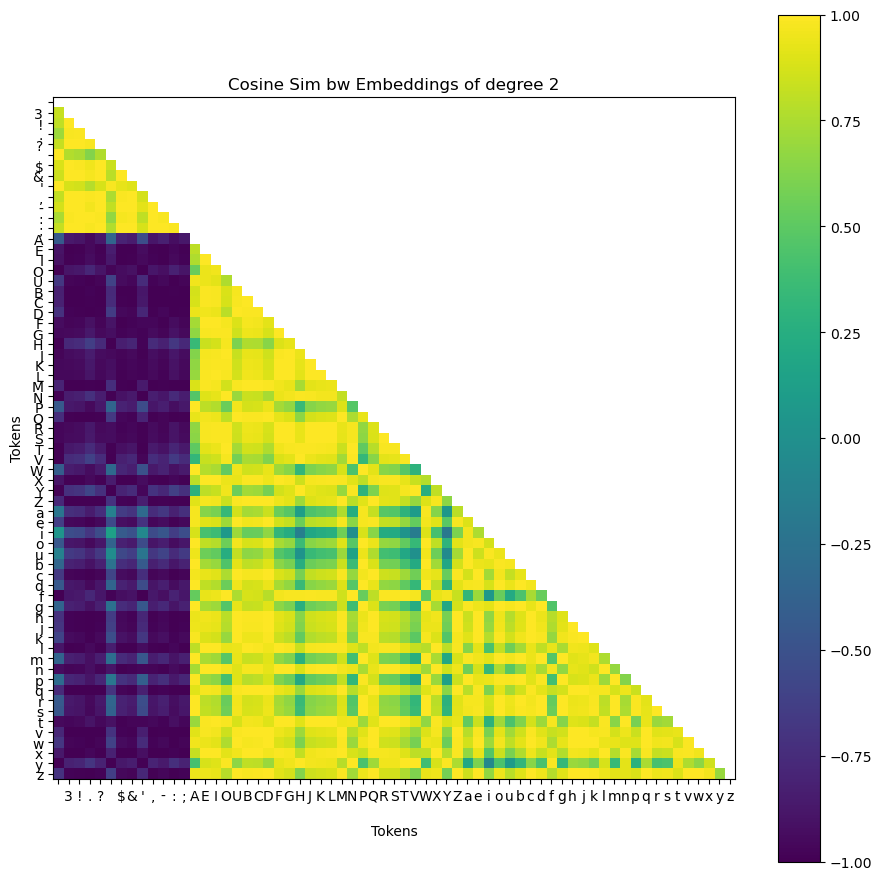

In [103]:
# selecting for symbols vs letters
save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_symbolsvsletters.png'
plot_token_similarity(chars1, model, stoi, degree=min_power, size=11, save_path=None)

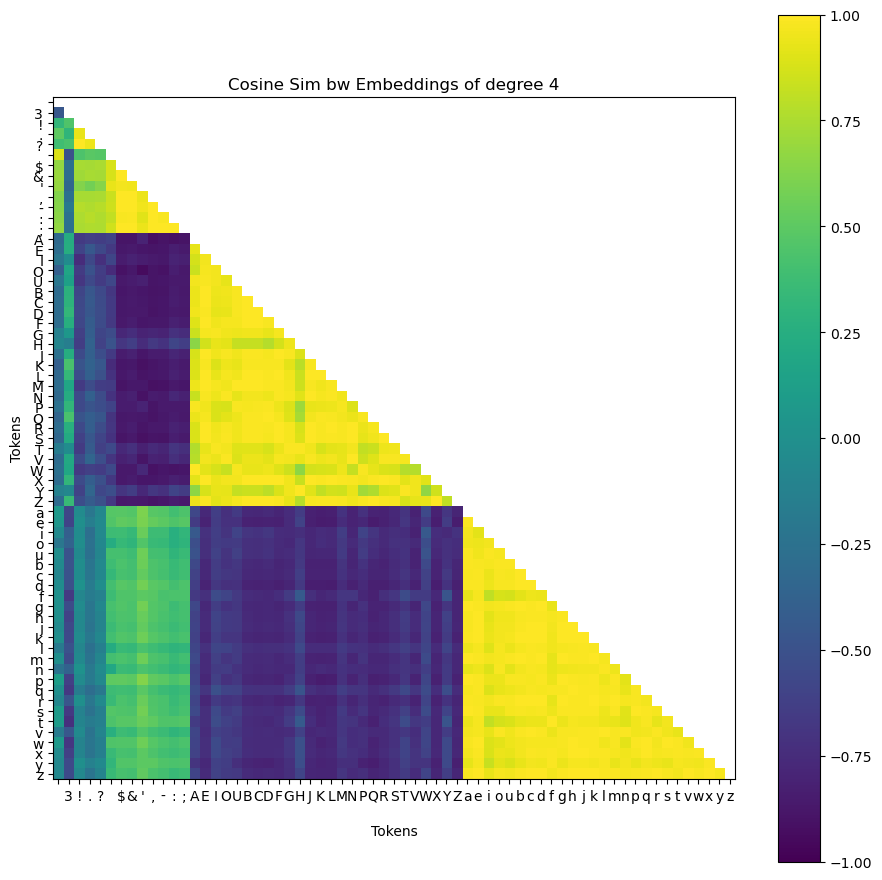

In [104]:
# selecting for endofsentence vs midsentence & uppercase vs lowercase
save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_endofsentencevsmidsentence&uppercasevslowercase.png'
plot_token_similarity(chars1, model, stoi, degree=min_power+1, size=11, save_path=None)

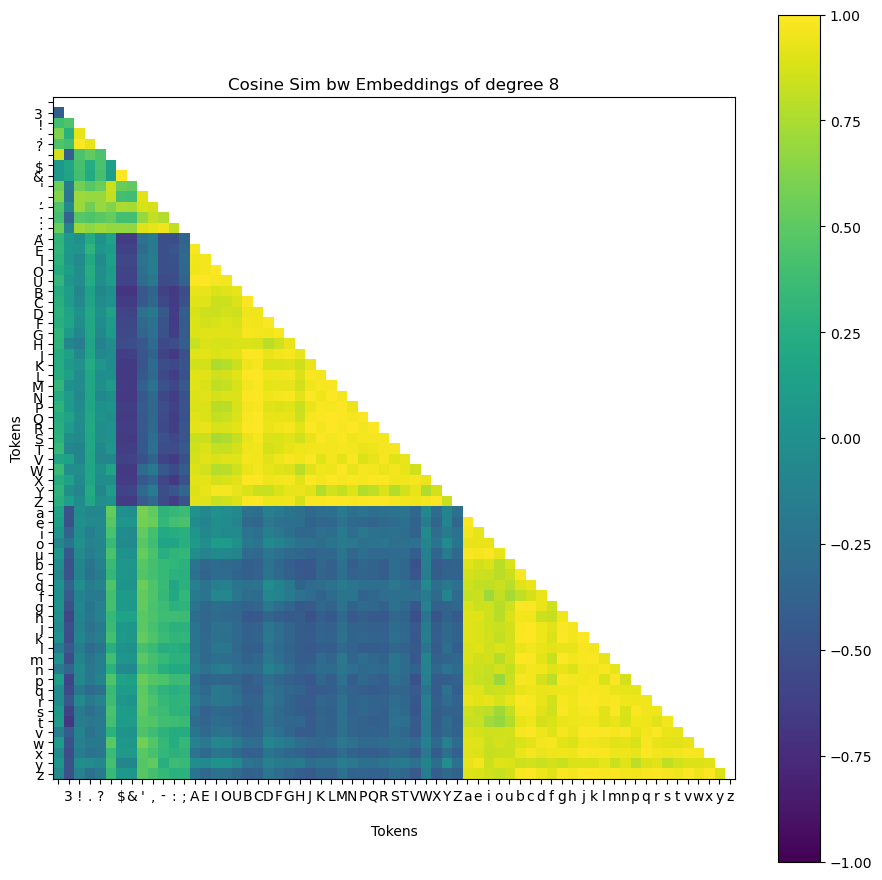

In [105]:
# selecting for spaces & vowels vs consonants
save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_spaces&vowelsvsconsonants.png'
plot_token_similarity(chars1, model, stoi, degree=min_power+2, size=11, save_path=None)

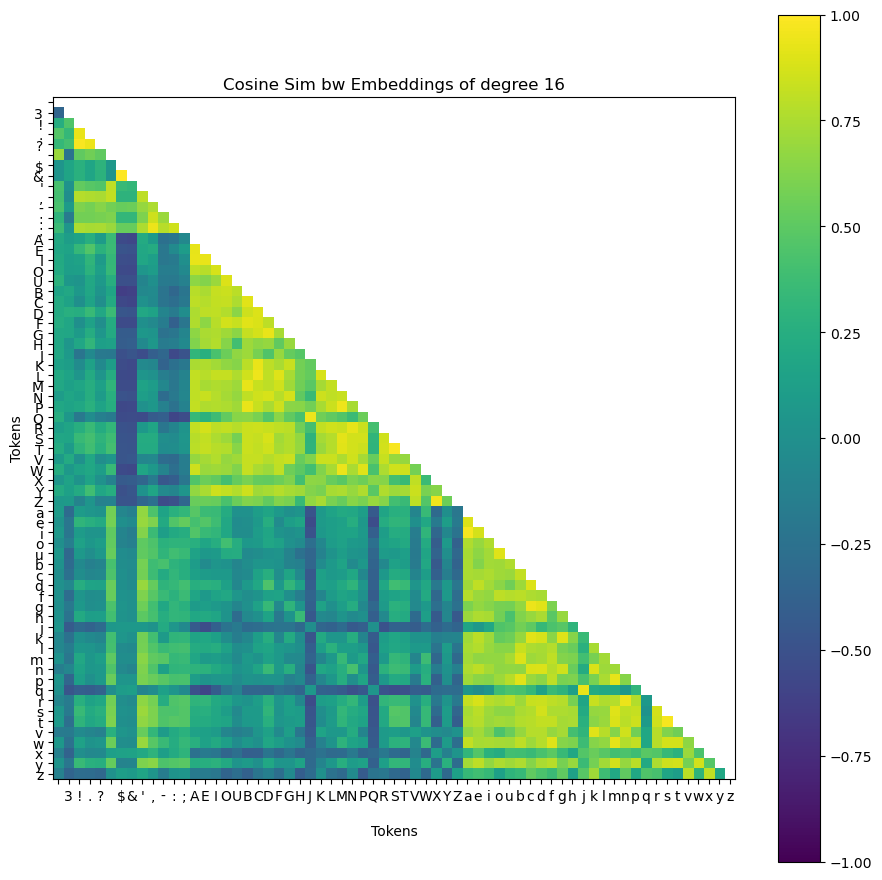

In [106]:
# selecting for the capital & lowercase version of each letter
save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_capital&lowercaseversionofeachletter.png'
plot_token_similarity(chars1, model, stoi, degree=power_of_d-1, size=11, save_path=None)

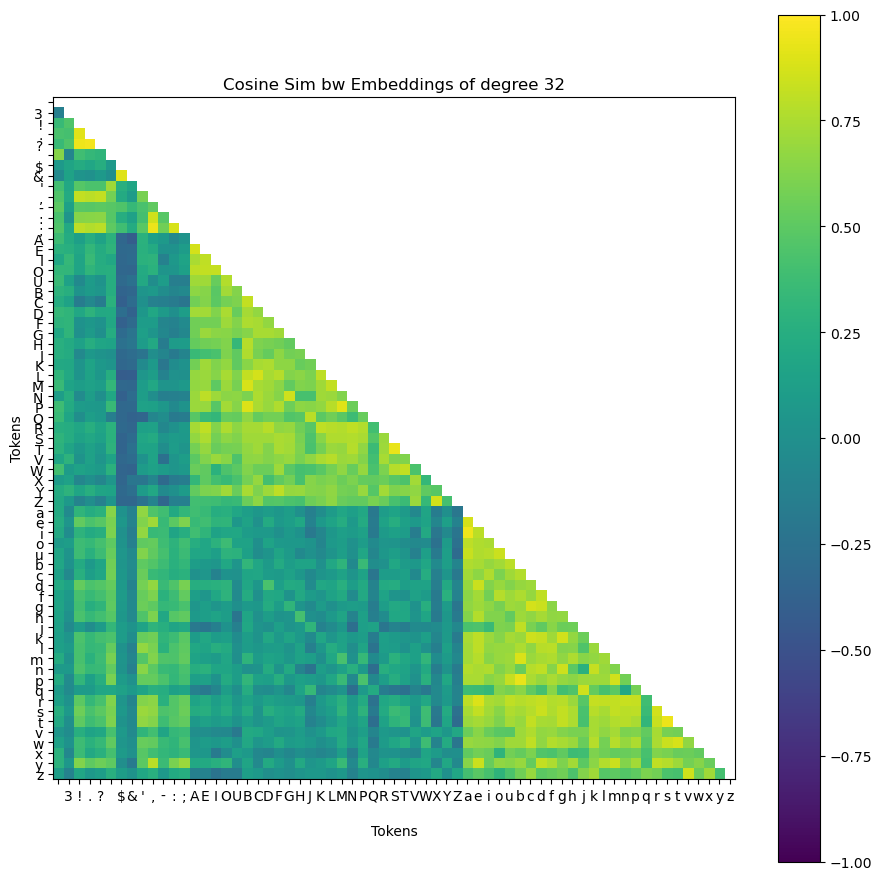

In [107]:
save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}.png'
plot_token_similarity(chars1, model, stoi, degree=power_of_d, size=11, save_path=None)

In [83]:
masks[3][-1,:]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.5000], device='mps:0')